In [8]:
import re
import torch
import utils
import random

import numpy as np
import pandas as pd

from collections import defaultdict, Counter
from minicons import cwe
from sklearn.decomposition import PCA
from string import Template
from torch.utils.data import DataLoader
from tqdm import tqdm

In [9]:
vlm = True

data_path = "../data/gqa_entities"

lemma_path = f"{data_path}/gqa-lemmas-annotated.csv"

lexicon = defaultdict(dict)
lemmas = utils.read_csv_dict(lemma_path)
lemmas = [l for l in lemmas if l["remove"] not in ["?", "1"]]
for entry in lemmas:
    lexicon[entry["lemma"]] = entry

lexicon["sports equiment"] = {
    "lemma": "sports equiment",
    "singular": "sports equiment",
    "plural": "sports equiment",
    "article": "sports equiment",
    "taxonomic_phrase": "are a type of",
    "novel_property_is": "",
    "novel_property_have": "",
    "generic": "p",
    "remove": "",
}

lexicon = dict(lexicon)

data = utils.read_csv_dict("../data/gqa_dataset/model_inference_output.tsv")
model_ids = defaultdict(list)

print(len(data))

if vlm:
    ids = utils.read_csv_dict("../data/gqa_dataset/qwen-vl-base-correct-no.csv")
else:
    ids = utils.read_csv_dict("../data/gqa_dataset/qwen-lm-base-correct-no.csv")

ids = [i['question_id'] for i in ids]

print(len(ids))

# question_types = [
#     "existAttrC",
#     "existAttrNotC",
#     "existMaterialC",
#     "existMaterialNotC",
# ]
question_types = ["existAttrC", "existAttrNotC", "existMaterialC", "existMaterialNotC", "existThatC", "existThatNotC"]

if vlm:
    target = "vlm"
    vision = True
    model_type = "vision_text"
    model_id = "vlm_text_qwen2.5VL"
else:
    target = "lm"
    vision = False
    model_type = "text_only"
    model_id = "lm_Qwen2.5_7B_Instruct"

exists_data = [
    d
    for d in data
    if d["question_type"] in question_types
    and d["substitution_hop"] not in ["0", "-100"]
    and d["question_id"] in ids
]

148020
3658


In [10]:
pos_samples = defaultdict(list)
neg_samples = defaultdict(list)

# target_descriptions
for td in exists_data:
    hops = int(td['substitution_hop'])

    if hops > 0:
        # final_descriptions.append(td)
        pos_samples[td['original_arg']].append(td)
    elif hops < 0:
        neg_samples[td['original_arg']].append(td)
    else:
        print(hops)

pos_samples = dict(pos_samples)
neg_samples = dict(neg_samples)

In [11]:
# {k:len(v) for k,v in neg_samples.items()}

final_descriptions = []
for k, v in pos_samples.items():
    final_descriptions.extend(v)

random.seed(1024)

for k, v in neg_samples.items():
    sampled = random.sample(v, len(pos_samples[k]))

    final_descriptions.extend(sampled)

In [12]:
# len(final_descriptions)

def chat_template(sentence, tok, system=None, instruct=True, vision=False):
    """
    A function that applies the model's chat template to simulate
    an interaction environment.
    """
    if instruct == True:
        if system is None:
            if not vision:
                return tok.apply_chat_template(
                    [{"role": "user", "content": sentence}],
                    tokenize=False,
                    add_generation_prompt=True,
                )
            else:
                return tok.apply_chat_template(
                    [{"role": "user", "content": [{"type": "text", "text": sentence}]}],
                    tokenize=False,
                    add_generation_prompt=True,
                )
        else:
            try:
                if not vision:
                    return tok.apply_chat_template(
                        [
                            {"role": "system", "content": system},
                            {"role": "user", "content": sentence},
                        ],
                        tokenize=False,
                        add_generation_prompt=True,
                    )
                else:
                    try:
                        return tok.apply_chat_template(
                            [
                                {
                                    "role": "system",
                                    "content": [{"type": "text", "text": system}],
                                },
                                {
                                    "role": "user",
                                    "content": [{"type": "text", "text": sentence}],
                                },
                            ],
                            tokenize=False,
                            add_generation_prompt=True,
                        )
                    except:
                        try:
                            # print("second error")
                            return tok.apply_chat_template(
                                [
                                    {
                                        "role": "system",
                                        "content": system,
                                    },
                                    {
                                        "role": "user",
                                        "content": [{"type": "text", "text": sentence}],
                                    },
                                ],
                                tokenize=False,
                                add_generation_prompt=True,
                            )
                        except:
                            # print("third error")
                            return tok.apply_chat_template(
                                [
                                    {
                                        "role": "user",
                                        "content": f"{system} {sentence}",
                                    },
                                ],
                                tokenize=False,
                                add_generation_prompt=True,
                            )
            except:
                return tok.apply_chat_template(
                    [
                        {
                            "role": "user",
                            "content": [
                                {"type": "text", "text": f"{system} {sentence}"}
                            ],
                        },
                    ],
                    tokenize=False,
                    add_generation_prompt=True,
                )
    elif isinstance(instruct, Template):
        return instruct.substitute(system=system, sentence=sentence)
    else:
        return f"{system} {sentence} Answer:"

In [13]:
lm = cwe.CWE("Qwen/Qwen2.5-VL-7B-Instruct", device = "cuda:0")
# lm = cwe.CWE("Qwen/Qwen2.5-7B-Instruct", device = "cuda:1")

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
# stimuli = [(chat_template("This is a sentence", lm.tokenizer, system=None, instruct=True, vision=False), "assistant")]

stimuli = []

for entry in final_descriptions:
    # surface_form = f"Description: {entry['scene_description']} Question: In the scene, {entry['question'].lower()} Answer:"
    surface_form = entry['input']
    model_input = chat_template(surface_form, lm.tokenizer, vision=vision)
    sub_hop = int(entry["substitution_hop"])

    if sub_hop > 0:
        subs_type = "hypernym"
    elif sub_hop == 0:
        subs_type = "original"
    else:
        subs_type = "negative"

    stimuli.append(
        {
            "question_id": entry["question_id"],
            "substitution_hop": sub_hop,
            "subs_type": subs_type,
            "concept": entry["original_arg"],
            "input": model_input,
            "type": model_type,
            # "correct": entry["lm_"],
            # 'type': 'text_only',
            'correct': entry[model_id]
        }
    )

In [15]:
batches = DataLoader(stimuli, batch_size=1)

In [16]:
len(stimuli)

16058

In [17]:
def extract_reps(lm, sentence_batch):
    padding_id = lm.tokenizer.pad_token_id
    encoded = lm.encode_text(sentence_batch)
    ids = encoded[0].tolist()

    idxes = [len([t for t in enc if t != padding_id]) - 1 for enc in ids]

    indexed = encoded[1][torch.arange(len(sentence_batch)), idxes]

    return indexed

In [18]:
reps = []

for batch in tqdm(batches):
    inputs = batch['input']

    embs = extract_reps(lm, inputs)
    # queries = batch['query']
    # paired = [(i, q) for i,q in zip(inputs, queries)] 

    # embs = lm.extract_representation(paired)

    reps.extend(embs)

100%|██████████| 16058/16058 [1:08:28<00:00,  3.91it/s]


In [19]:
reps_np = torch.stack(reps).numpy()

In [20]:
pca = PCA(n_components=3)
reps_pca = pca.fit(reps_np).transform(reps_np)

print(pca.explained_variance_ratio_)

[0.32141748 0.1366949  0.09516662]


In [21]:
# VLM: sum([0.34139356, 0.1334128 ]) 0.47480636
# LM: 
sum([0.3433121,  0.13555627]), sum([0.38439855, 0.12783593])

(0.47886837000000004, 0.51223448)

In [22]:
reps_pca

array([[ -5.6445847, -26.09274  , -12.98313  ],
       [ 17.01369  , -27.372787 ,  -7.212881 ],
       [  9.266605 , -13.038052 ,  -3.941119 ],
       ...,
       [ -6.7170525,  29.262691 ,  23.382559 ],
       [ 19.372864 ,   5.823266 ,  17.217844 ],
       [-50.18454  ,  15.417916 ,  10.502043 ]], dtype=float32)

In [23]:
reps_pca_df = pd.DataFrame(reps_pca, columns=['x', 'y', 'z'])
stimuli_df = pd.DataFrame(stimuli)

joined = pd.concat([stimuli_df, reps_pca_df], axis = 1)

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='x', ylabel='y'>

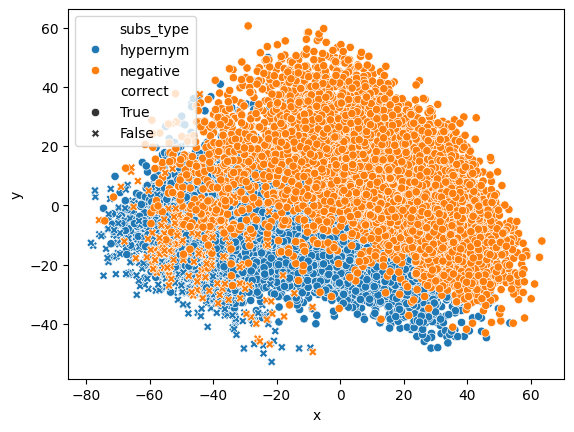

In [25]:
sns.scatterplot(data=joined, x="x", y="y", hue = "subs_type", style="correct")

In [26]:
joined.to_csv(f"../pca-data/qwen-2.5-7b-instruct-{model_type}.csv", index=False)
# joined.to_csv("../pca-data/qwen-2.5-7b-instruct-text-equal.csv", index=False)